In [ ]:
# install.packages("tensorflow")

In [ ]:
# install.packages('pracma')

In [ ]:
# install.packages('stringr')

In [ ]:
# install.packages('keras')

In [1]:
library(keras)

In [2]:
options(warn = -1)
library(pracma)
library(tibble)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2)
library(tidyr)
library(stringr)
library(ggthemes)

# Machine Learning using Neural Networks (Part 2)

Welcome to the tutorial on Machine Learning using Neural Networks! In this part of the tutorial, we will use neural networks to recognize handwritten digits. Will will start by outlining why neural networks are good for recognizing images, and then train a neural network to recognize handwritten digits. We will use a famous dataset for this task, which is called MNIST.

Let's get started!

## Image Recognition using Neural Networks

How can computer programs recognize objects in a photograph? This has been one of the central questions in the computer vision research. It is very simple for humans to recognize objects in the photographs, just like we do in real world. But for computers, this task becomes notoriously difficult! Although with a little help from neural networks, it becomes rather easy because neural networks behave in a slightly intuitive way. Here is how a neural network would recognize whether there is a face in an image or not:

<img src="
./mnist/imgrecog_1.png"/>

What you see in the image above essentially tell us that neural networks try to recognize different 'features' of the image first, and based on appearance of those features, they decide whether the image contains the signal of interest or not (a human face in this case).

The problem of detecting a face in a photograph is a binary classification problem, but for our example, we are going to turn to a multi-class classification problem.

## Example: Recognizing Handwritten Digits using Neural Networks

To explore how to recognize images, we will try train a neural network model that can tell us which handwritten digit is there in the image we give to it. We are going to use a database of images that was originally developed in 1994 called the MNIST dataset. It is based on samples of high school students and U. S. Census Bureau employees' writing- https://en.wikipedia.org/wiki/MNIST_database

<img src="mnist/mnist_1.png"/>

You can see that there are many different ways of wriring 0s, 1s, 2s, and so on. How is neural network going to detect which digit is there in the image? It turns out that neural network will try to break down the problem in parts and work it out.

## Representing Images as Data

In order to use a neural network to recognize images, we must first convert images into numeric values. Each image is translated into a matrix of values. We will first read in the MNIST data and then plot it to demonstrate what inputs are required in neural networks.

The MNIST dataset contains many thousand training examples for handwritten digits. Each training example is a 28x28 pixel image. This means that we have 28x28 = 784 features for each of our training example. As the output, we have a numeric value from 0 to 9, which tells the actual digit that is stored in those 784 pixels. We are going to use this information to train and evalulate our model.

In [133]:
mnist <- dataset_mnist()
x_train <- mnist$train$x
y_train <- mnist$train$y
x_test <- mnist$test$x
y_test <- mnist$test$y

In [134]:
# reshape
x_train <- array_reshape(x_train, c(nrow(x_train), 784))
x_test <- array_reshape(x_test, c(nrow(x_test), 784))
# rescale
x_train <- x_train / 255
x_test <- x_test / 255

Before we jump further in, you might ask, what do these 784 pixels contain? They contain what is called pixel intensity value that indicates how dark the pixel is. If we print these pixel intensity values, we get to see the actual image. Here is an example:

In [135]:
data.frame(x_train) -> x_train_tab

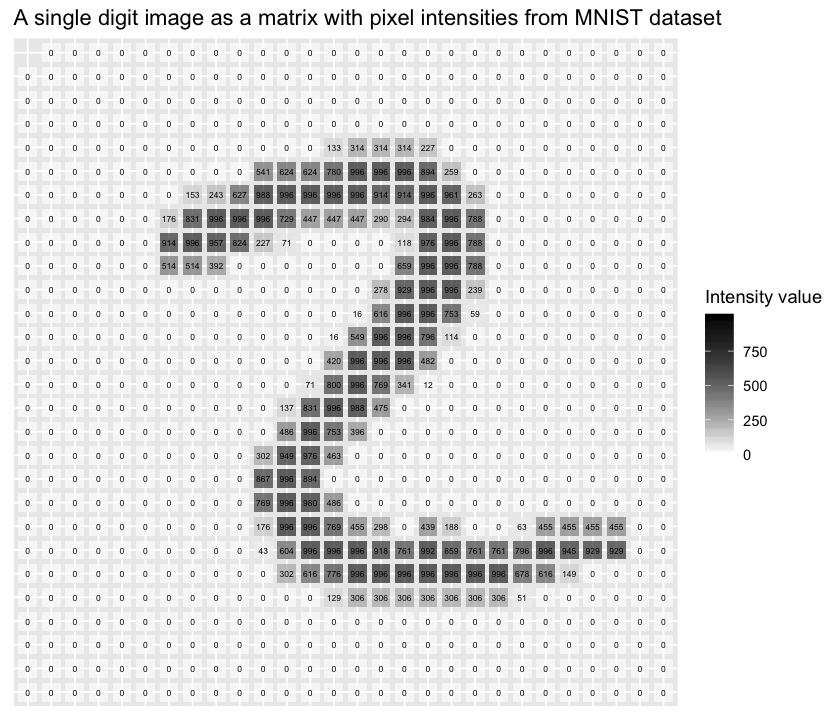

In [145]:
options(repr.plot.width = 7, repr.plot.height = 6)

x_train_tab %>%
  slice(77) %>%
  mutate(example = row_number()) %>%
  gather(key = pixnum, value = inten) %>%
  mutate(inten=round(inten,3)*1000) %>%
  mutate(pixnum = as.integer(str_replace(pixnum, "X", "")),
         x = factor(floor(pixnum / 28) + 1, 28:1),
         y = factor(pixnum %% 28 + 1, 1:28)) %>%
  drop_na() %>%
  ggplot(aes(y, x)) +
  geom_tile(aes(fill = inten, width = .8, height = .8), size = 1, alpha = .6) +
  geom_text(aes(label = inten), size = 1.8, color = "black") +
  scale_fill_continuous(low = "white", high = "black") +
  theme(axis.ticks = element_blank(),
        axis.text = element_blank(),
        axis.title = element_blank()) +
  labs(fill = "Intensity value", title = "A single digit image as a matrix with pixel intensities from MNIST dataset")

## Conceptually, How Could an Algorithm Detect a Zero from Many Different Examples?

Let us say the neural network is trying to detect whether there is 0 in the image or not. It will proceed like this:

- Detect handwriting strokes in different parts of the image
- Put these strokes together to figure out what digit is there in the image

For a 0, we might have these strokes in the image:

<img src="mnist/mnist_2.png" width=350/>

where the final image looks like this:

<img src="mnist/mnist_3.png" width=105/>

And remember, there can be many different types of 0s! But most of them will have circular strokes in all four sides of the image.

The code below plots images that were labled (the training data) as zeros.

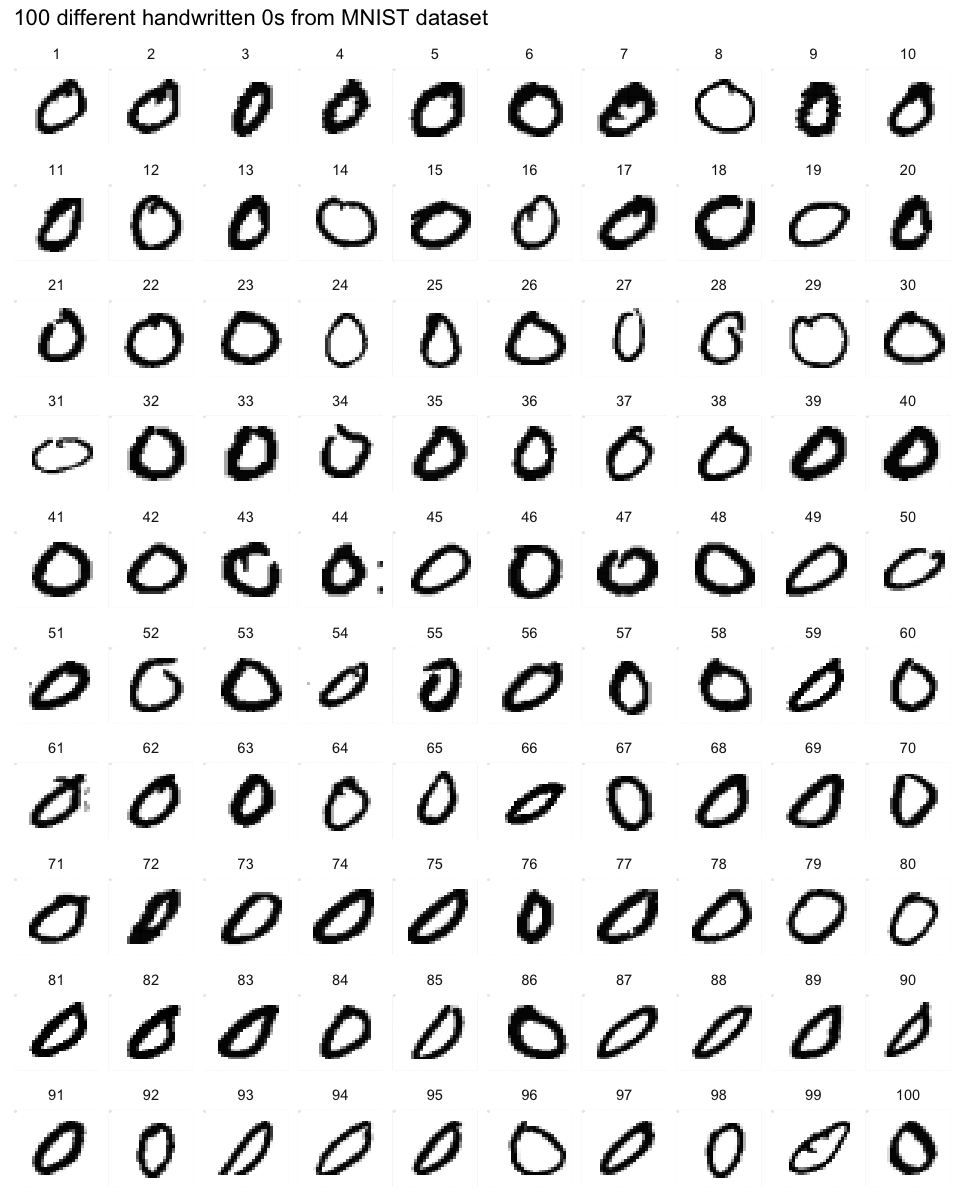

In [136]:
x_train_tib %>%
mutate(label = y_train) -> x_y_train

zero_pos <- which(x_y_train$label == 0)

options(repr.plot.width = 8, repr.plot.height = 10)

x_y_train %>%
  slice(zero_pos[1:100]) %>%
  mutate(example = row_number()) %>%
  gather(key = pixnum, value = inten, -example, -label) %>%
  mutate(inten=round(inten,3)*1000) %>%
  mutate(pixnum = as.integer(str_replace(pixnum, "X", "")),
         x = factor(floor(pixnum / 28) + 1, 28:1),
         y = factor(pixnum %% 28 + 1, 1:28)) %>%
  drop_na() %>%
  ggplot(aes(y, x)) +
  geom_tile(aes(fill = inten)) +
  facet_wrap(~ example, nrow = 10) +
  scale_fill_continuous(low = "white", high = "black") +
  theme_minimal() +
  theme(legend.position = "none",
        axis.ticks = element_blank(),
        axis.text = element_blank(),
        axis.title = element_blank()) +
  ggtitle("100 different handwritten 0s from MNIST dataset")

### Detecting 0 to 9

So you now have a rough idea about how can a neural network detect 0 in an image. However, we need to detect all the digits, from 0 to 9. How will we do this using using a neural network?

So far, we have only talked about binary outcomes where a neural network is detecting whether there is 'some thing' present in its input or not. This requires us to have one neuron in the output layer. But if we want to detect multiple things, we need to have multiple neurons in the output layer, one for each thing we need to detect. In our case, we need to detect all the arabic numerals, so there will be 10 output nodes. Here is what our neural network will look like:

<img src="mnist/mnist_4.png"/>

Let us find out where those 784 input neurons are coming from.

We are going to feed a lot of these images to our neural network, and it will learn characteristics of different digits for us. Then we can use this trained model to make predictions.

### Model Training

Let us start the model training by looking at the the dataset. We will use <b>Tensorflow</b> (https://tensorflow.rstudio.com/) package for our machine learning task via the library keras (https://keras.rstudio.com/). Here are some rows from our dataset:

Our training set will have 48,000 samples and  12,000 validation examples.

Next, we will organize the data into objects representing the x and y variables.

In [138]:
y_train <- to_categorical(y_train, 10)
y_test <- to_categorical(y_test, 10)

Now we will configure our neural network.

In [83]:
model <- keras_model_sequential() 
model %>% 
  layer_dense(units = 256, activation = 'relu', input_shape = c(784)) %>% 
  layer_dropout(rate = 0.4) %>% 
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = 10, activation = 'softmax')

In [84]:
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_1 (Dense)                     (None, 256)                     200960      
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 256)                     0           
________________________________________________________________________________
dense_2 (Dense)                     (None, 128)                     32896       
________________________________________________________________________________
dropout_2 (Dropout)                 (None, 128)                     0           
________________________________________________________________________________
dense_3 (Dense)                     (None, 10)                      1290        
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_____________________________________

In [85]:
model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_rmsprop(),
  metrics = c('accuracy')
)

Now it is time to train the model!

In [146]:
trained_model <- model %>% fit(
  x_train, y_train, 
  epochs = 30, batch_size = 128, 
  validation_split = 0.2
)

In [147]:
trained_model

Trained on 48,000 samples, validated on 12,000 samples (batch_size=128, epochs=30)
Final epoch (plot to see history):
val_loss: 0.1407
 val_acc: 0.9792
    loss: 0.04683
     acc: 0.9894 

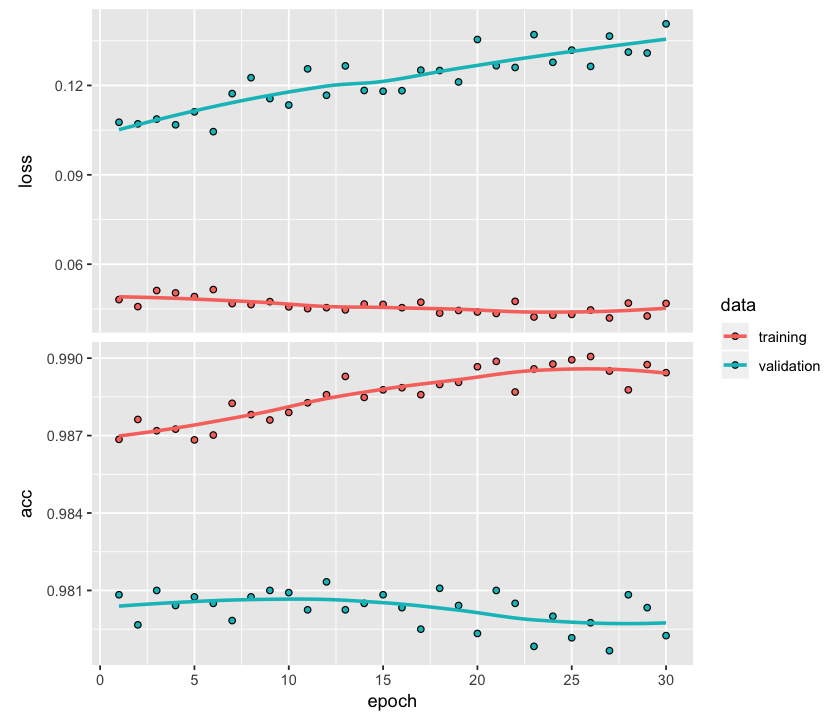

In [148]:
plot(trained_model)

Now that our model is trained, we will generate some predictions and assess the accuracy. <b>Remember, always assess accuracy using test data!</b>

### Model Evaluation

In [95]:
model %>% evaluate(x_test, y_test)

$loss
[1] 0.09972231

$acc
[1] 0.9815

We can look at the distribution of the answers in a comparison matrix.

In [97]:
model %>% predict_classes(x_test) -> pred

In [117]:
table(pred = pred, orig = max.col(y_test)-1)

    orig
pred    0    1    2    3    4    5    6    7    8    9
   0  973    0    2    0    1    2    4    2    4    2
   1    1 1126    2    0    1    1    3    5    3    4
   2    1    4 1014    4    3    0    0    8    2    0
   3    1    1    1  994    0    7    1    4    3    3
   4    0    0    1    0  956    1    4    0    2    6
   5    1    1    0    6    0  871    3    0    5    1
   6    1    1    1    0    3    3  939    0    1    0
   7    1    1    5    3    2    2    0 1004    2    3
   8    1    1    6    3    2    3    4    0  948    0
   9    0    0    0    0   14    2    0    5    4  990

Look at the missed predictions.  Do you see a pattern?

Let us calculate the test accuracy of the model.

In [120]:
pct_accuracy <- mean(pred == max.col(y_test)-1)
cat("Test accuracy of the model is", pct_accuracy * 100, "%\n")

Test accuracy of the model is 98.15 %


Not bad. How can we improve this model? There are different ways to improve predictions of a neural network:

- <b>Change architecture</b>
- <b>Try different hyperparameters</b>
- <b>Try advanced methods like convolution</b>

Trying these different things is out of the scope of this tutorial, but if you want to explore these options, you can do so in <a href="https://playground.tensorflow.org">TensorFlow Playground</a>.

## Conclusion

In this part of the tutorial, we saw how neural networks are trained using software packages. Don't worry if this was too complicated, you always get help about doing complex things when working in teams. Websites like [StackOverflow](https://stackoverflow.com/) can also help in case you get stuck.

We hope that you found both part 1 and part 2 of the tutorial useful.

## References

We would like to thank Michael Nielson for his excellent online textbook on neural networks. We extensively borrowed part 1 materials from his textbook which can be found <a href="http://neuralnetworksanddeeplearning.com">here</a>.

For part 2, we used the mxnet example presented <a href="https://mxnet.incubator.apache.org/tutorials/r/mnistCompetition.html">here</a>, but modified it according to our neural network architecture.